# 2. Unconfined Aquifer Test - Moench Example

Test for an anisotropic water-table aquifer.

**This test is taken from examples presented in MLU tutorial.**

### Import required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim as ttm

plt.rcParams["figure.figsize"] = [5, 3]

### Introduction and Conceptual Model

This test is based on a synthetic example reported by Barlow and Moench (1999), utilizing an analytical solution developed by Moench and Allen (1997) for the transient flow of partially-penetrating wells in unconfined aquifers. The data reported has been used in MLU (Carlson and Randall, 2012) to check the model performance.

We will reproduce the work of Yang (2020) to explore the performance of anisotropic water table aquifer modelling with TTim and compare the results with the published values and the MLU solution.

The conceptual model of the test is of an aquifer, partially saturated with water (10 m water table). A pumping well is screened from 5 to 10 m depth. The well and the well-casing radius is 0.1 m. Drawdown is recorded at the pumping well and four piezometers located at two different distances and two different depths. Two piezometers, PS1 and PS2, are located at one-meter depth below the water table and 3.16 and 31.6 m distance, respectively. Another two (PD1 and PD2) piezometers are at 7.5 m depth below the water table and the same distances,  directly below the previous piezometers. The figure below shows the location of the well and the piezometers

Pumping starts at time t = 0 at a constant rate of 172.8 m3/d. Drawdown is recorded until t = 3 days.

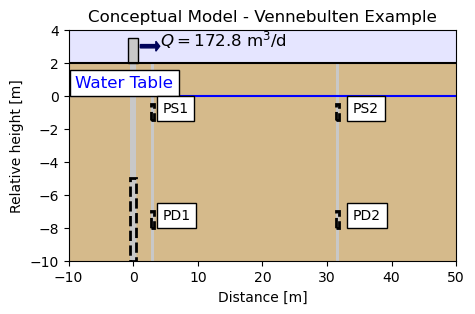

In [3]:
import matplotlib.pyplot as plt

##Now printing the conceptual model figure:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-20, 2), width=70, height=5, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-20, -10),
    width=70,
    height=12,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)


well = plt.Rectangle(
    (-0.5, -10), width=1, height=12, fc=np.array([200, 200, 200]) / 255, zorder=1
)
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle(
    (-0.75, 2),
    width=1.5,
    height=1.5,
    fc=np.array([200, 200, 200]) / 255,
    zorder=2,
    ec="k",
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-0.5, -10),
    width=1,
    height=5,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x=1.1, y=3, dx=3, dy=0, color="#00035b")
ax.add_patch(pumping_arrow)
ax.text(x=4.2, y=3, s=r"$ Q = 172.8$ m$^3$/d", fontsize="large")

# Piezometers
piez1 = plt.Rectangle(
    (31.4, -10), width=0.5, height=12, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_1 = plt.Rectangle(
    (31.4, -8),
    width=0.5,
    height=1,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_1.set_linewidth(2)
screen_piez_2 = plt.Rectangle(
    (31.4, -1.5),
    width=0.5,
    height=1,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_2.set_linewidth(2)

ax.add_patch(piez1)
ax.add_patch(screen_piez_1)
ax.add_patch(screen_piez_2)

piez2 = plt.Rectangle(
    (2.75, -10), width=0.5, height=12, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_3 = plt.Rectangle(
    (2.75, -8),
    width=0.5,
    height=1,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_3.set_linewidth(2)
screen_piez_4 = plt.Rectangle(
    (2.75, -1.5),
    width=0.5,
    height=1,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_4.set_linewidth(2)

ax.add_patch(piez2)
ax.add_patch(screen_piez_3)
ax.add_patch(screen_piez_4)

# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[2, 2], color="k")
ax.add_line(line)

# Water table
line2 = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="b")
ax.add_line(line2)

ax.text(-9, 0.5, s="Water Table", fontsize="large", color="b", bbox={"fc": "w"})
ax.text(4.5, -1, s="PS1", bbox={"fc": "w"})
ax.text(34, -1, s="PS2", bbox={"fc": "w"})
ax.text(4.5, -7.5, s="PD1", bbox={"fc": "w"})
ax.text(34, -7.5, s="PD2", bbox={"fc": "w"})

ax.set_xlim([-10, 50])
ax.set_ylim([-10, 4])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model - Vennebulten Example");

## Step 2. Set basic parameters

In [5]:
b = 10  # aquifer thickness, m
Q = 172.8  # constant discharge rate, m^3/d
rw = 0.1  # well radius, m
rc = 0.1  # casing radius, m
r1 = 3.16  # distance of closer wells, m
r2 = 31.6  # distance of wells more far away, m

## Step 3. Load datasets of observation wells

The dataset for each well consists of a column with the time data in seconds and drawdown in meters. We are loading it and converting it to days and meters.

In [6]:
data0 = np.loadtxt("data/moench_pumped.txt", skiprows=1)
t0 = data0[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h0 = -data0[:, 1]  # converting drawdown to heads
data1 = np.loadtxt("data/moench_ps1.txt", skiprows=1)
t1 = data1[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h1 = -data1[:, 1]
data2 = np.loadtxt("data/moench_pd1.txt", skiprows=1)
t2 = data2[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h2 = -data2[:, 1]
data3 = np.loadtxt("data/moench_ps2.txt", skiprows=1)
t3 = data3[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h3 = -data3[:, 1]
data4 = np.loadtxt("data/moench_pd2.txt", skiprows=1)
t4 = data4[:, 0] / 60 / 60 / 24  # convert time from seconds to days
h4 = -data4[:, 1]

## Step 4. Creating a TTim model

We will create an initial model divided in the same way as in the MLU documentation. A first layer with 0.1 m thick and phreatic storage, followed by a 2 m thick layer where the shallow piezometers are located, a 3 m layer and finally, a 5 m layer where the pump is placed and the last piezometers are screened. Additionally, we will set the model parameters with the given ones in Barlow and Moench (1999) and compare the results with the heads given in the paper.

In [8]:
# Set kaq, Saq, Sy and kzoverkh as given in Moench (1997)
kaq = 1e-4 * 60 * 60 * 24  # convert from m/s to m/d
Sy = 0.2
Saq = 2e-5
kzoverkh = 0.5  # kzoverkh

In [53]:
ml1 = ttm.Model3D(
    kaq=kaq,
    z=[0, -0.1, -2.1, -5.1, -10.1],
    Saq=[Sy, Saq, Saq, Saq],
    kzoverkh=kzoverkh,
    tmin=1e-5,
    tmax=3,
    phreatictop=True,
)
w1 = ttm.Well(ml1, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, Q)], layers=[3])
ml1.solve()

self.neq  1
solution complete


### Check the TTim model with values obtained by Moench

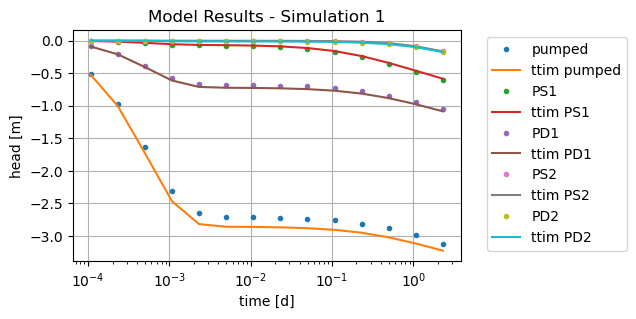

In [57]:
hm0 = w1.headinside(t0)[0]
hm1 = ml1.head(r1, 0, t1, layers=1)[0]
hm2 = ml1.head(r1, 0, t2, layers=3)[0]
hm3 = ml1.head(r2, 0, t3, layers=1)[0]
hm4 = ml1.head(r2, 0, t4, layers=3)[0]
plt.semilogx(t0, h0, ".", label="pumped")
plt.semilogx(t0, hm0, label="ttim pumped")
plt.semilogx(t1, h1, ".", label="PS1")
plt.semilogx(t1, hm1, label="ttim PS1")
plt.semilogx(t2, h2, ".", label="PD1")
plt.semilogx(t2, hm2, label="ttim PD1")
plt.semilogx(t3, h3, ".", label="PS2")
plt.semilogx(t3, hm3, label="ttim PS2")
plt.semilogx(t4, h4, ".", label="PD2")
plt.semilogx(t4, hm4, label="ttim PD2")
plt.xlabel("time [d]")
plt.ylabel("head [m]")
plt.title("Model Results - Simulation 1")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()

Visually, TTim's solution is close to Moench's solution, but not quite the same.

### Calculate RMSE of TTim model

In [58]:
rmse = np.sqrt(
    np.sum(
        np.sum((h1 - hm1) ** 2)
        + np.sum((h2 - hm2) ** 2)
        + np.sum((h3 - hm3) ** 2)
        + np.sum((h4 - hm4) ** 2)
        + np.sum((h0 - hm0) ** 2)
    )
    / (len(h1) + len(h2) + len(h3) + len(h4) + len(h0))
)

print("RMSE:", rmse)

RMSE: 0.06131793579847181


The model has obtained a very close result with a good approximation to the analytical solution.

## Step 6. Model Calibration

Now, instead of using the given values, we will try to find them through the TTim optimization framework. One can learn more about the calibration procedure and how to set the parameters in the following notebook: [Unconfined Test - Vennebulten](unconfined1_vennebulten.ipynb)

In [59]:
ml2 = ttm.Model3D(
    kaq=1,
    z=[0, -0.1, -2.1, -5.1, -10.1],
    Saq=[0.1, 1e-4, 1e-4, 1e-4],
    kzoverkh=1,
    tmin=1e-5,
    tmax=3,
    phreatictop=True,
)
w2 = ttm.Well(ml2, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, Q)], layers=3)
ml2.solve()

self.neq  1
solution complete


In [60]:
ca2 = ttm.Calibrate(ml2)
ca2.set_parameter(name="kaq0_3", initial=1)
ca2.set_parameter(name="Saq0", initial=0.2)
ca2.set_parameter(name="Saq1_3", initial=1e-4, pmin=0)
ca2.set_parameter(name="kzoverkh0_3", initial=0.1, pmin=0)
ca2.seriesinwell(name="pumped", element=w2, t=t0, h=h0)
ca2.series(name="PS1", x=r1, y=0, t=t1, h=h1, layer=1)
ca2.series(name="PD1", x=r1, y=0, t=t2, h=h2, layer=3)
ca2.series(name="PS2", x=r2, y=0, t=t3, h=h3, layer=1)
ca2.series(name="PD2", x=r2, y=0, t=t4, h=h4, layer=3)
ca2.fit()

..................................................................
Fit succeeded.


In [61]:
display(ca2.parameters)
print("RMSE:", ca2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_3,9.067633,0.022352,0.246505,-inf,inf,1.0000,"[9.06763268224383, 9.06763268224383, 9.0676326..."
Saq0,0.172888,0.004374,2.529859,-inf,inf,0.2000,[0.17288811536695828]
Saq1_3,0.000039,0.000004,9.175881,0.0,inf,0.0001,"[3.8713577102722496e-05, 3.8713577102722496e-0..."
kzoverkh0_3,0.535053,0.010142,1.895517,0.0,inf,0.1000,"[0.5350534715216693, 0.5350534715216693, 0.535..."


RMSE: 0.010384176554876806


The values are close to the values in Moench.

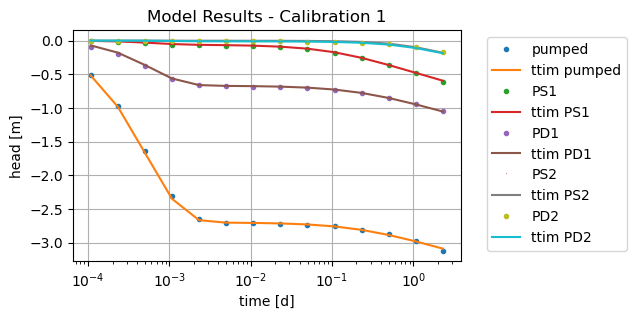

In [62]:
hm0_2 = ml2.head(0, 0, t0, layers=3)[0]
hm1_2 = ml2.head(r1, 0, t1, layers=1)[0]
hm2_2 = ml2.head(r1, 0, t2, layers=3)[0]
hm3_2 = ml2.head(r2, 0, t3, layers=1)[0]
hm4_2 = ml2.head(r2, 0, t4, layers=3)[0]
plt.semilogx(t0, h0, ".", label="pumped")
plt.semilogx(t0, hm0_2, label="ttim pumped")
plt.semilogx(t1, h1, ".", label="PS1")
plt.semilogx(t1, hm1_2, label="ttim PS1")
plt.semilogx(t2, h2, ".", label="PD1")
plt.semilogx(t2, hm2_2, label="ttim PD1")
plt.semilogx(t3, h3, ",", label="PS2")
plt.semilogx(t3, hm3_2, label="ttim PS2")
plt.semilogx(t4, h4, ".", label="PD2")
plt.semilogx(t4, hm4_2, label="ttim PD2")
plt.xlabel("time [d]")
plt.ylabel("head [m]")
plt.title("Model Results - Calibration 1")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()

### More layers

The calibration resulted in a lower error than the simulated model, which could mean that we could improve the conceptualization of the model in TTim. In this next step, we will increase the number of layers to better account for the vertical flow component. We will create an 18-layers model with 0.5 m thick layers, except at the layers in the piezometers where a 1 m thickness has been established to make sure the piezometers lie at the centre of the layer:

In [63]:
## Model Configuration:

nlay = 18
zlayers = np.concatenate(
    (
        np.array([0, -0.5, -1.5]),
        np.linspace(-2, -7, 11),
        np.array([-8, -8.5, -9, -9.5, -10]),
    )
)  # elevation of each layer
Saq_n = 1e-4 * np.ones(nlay)
Saq_n[0] = 0.1  # Setting the first storage as specific yield
print(zlayers)
print(Saq)

[  0.   -0.5  -1.5  -2.   -2.5  -3.   -3.5  -4.   -4.5  -5.   -5.5  -6.
  -6.5  -7.   -8.   -8.5  -9.   -9.5 -10. ]
2e-05


In [46]:
Saq_n

array([0.1   , 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001])

In [64]:
ml3 = ttm.Model3D(
    kaq=1, z=zlayers, Saq=Saq_n, kzoverkh=1, tmin=1e-5, tmax=3, phreatictop=True
)
w3 = ttm.Well(ml3, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, Q)], layers=range(9, 18))
ml3.solve()

self.neq  9
solution complete


In [65]:
ca3 = ttm.Calibrate(ml3)
ca3.set_parameter(name="kaq0_19", initial=1, pmin=0)
ca3.set_parameter(name="Saq0", initial=0.2, pmin=0)
ca3.set_parameter(name="Saq1_19", initial=1e-4, pmin=0)
ca3.set_parameter(name="kzoverkh0_19", initial=0.1, pmin=0)
ca3.seriesinwell(name="well", element=w3, t=t0, h=h0)
ca3.series(name="PS1", x=r1, y=0, t=t1, h=h1, layer=1)
ca3.series(name="PD1", x=r1, y=0, t=t2, h=h2, layer=13)
ca3.series(name="PS2", x=r2, y=0, t=t3, h=h3, layer=1)
ca3.series(name="PD2", x=r2, y=0, t=t4, h=h4, layer=13)
ca3.fit()

.........................................................
Fit succeeded.


In [66]:
display(ca3.parameters)
print("RMSE:", ca3.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_19,8.695434,0.020723,0.238320,0,inf,1.0000,"[8.695433717306143, 8.695433717306143, 8.69543..."
Saq0,0.196104,0.004616,2.354037,0,inf,0.2000,[0.1961037602402571]
Saq1_19,0.000039,0.000003,8.513175,0,inf,0.0001,"[3.8988993330990596e-05, 3.8988993330990596e-0..."
kzoverkh0_19,0.488059,0.008575,1.756888,0,inf,0.1000,"[0.48805919609868, 0.48805919609868, 0.4880591..."


RMSE: 0.009766722717519069


In [67]:
display(ca3.parameters)
print("RMSE:", ca3.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_19,8.695434,0.020723,0.238320,0,inf,1.0000,"[8.695433717306143, 8.695433717306143, 8.69543..."
Saq0,0.196104,0.004616,2.354037,0,inf,0.2000,[0.1961037602402571]
Saq1_19,0.000039,0.000003,8.513175,0,inf,0.0001,"[3.8988993330990596e-05, 3.8988993330990596e-0..."
kzoverkh0_19,0.488059,0.008575,1.756888,0,inf,0.1000,"[0.48805919609868, 0.48805919609868, 0.4880591..."


RMSE: 0.009766722717519069


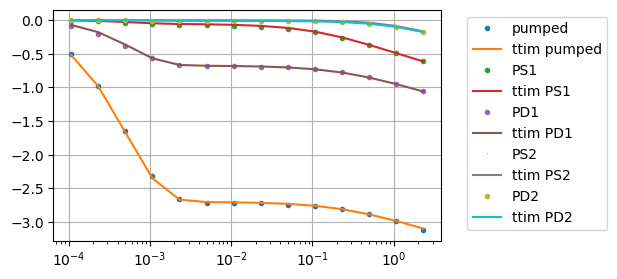

In [70]:
hm0_3 = ml3.head(0, 0, t0, layers=15)[0]
hm1_3 = ml3.head(r1, 0, t1, layers=1)[0]
hm2_3 = ml3.head(r1, 0, t2, layers=13)[0]
hm3_3 = ml3.head(r2, 0, t3, layers=1)[0]
hm4_3 = ml3.head(r2, 0, t4, layers=13)[0]
plt.semilogx(t0, h0, ".", label="pumped")
plt.semilogx(t0, hm0_3, label="ttim pumped")
plt.semilogx(t1, h1, ".", label="PS1")
plt.semilogx(t1, hm1_3, label="ttim PS1")
plt.semilogx(t2, h2, ".", label="PD1")
plt.semilogx(t2, hm2_3, label="ttim PD1")
plt.semilogx(t3, h3, ",", label="PS2")
plt.semilogx(t3, hm3_3, label="ttim PS2")
plt.semilogx(t4, h4, ".", label="PD2")
plt.semilogx(t4, hm4_3, label="ttim PD2")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()

Increasing the number of layers has not improved the model calibration performance. Let's see how the model behaves with the same parameters from the analytical solution:

### Step 7.1. Simulating multi-layered model with Moench's parameters

In [72]:
ml4 = ttm.Model3D(
    kaq=kaq,
    z=zlayers,
    Saq=[Sy] + list(np.repeat(Saq, nlay - 1)),
    kzoverkh=kzoverkh,
    tmin=1e-5,
    tmax=3,
)
w4 = ttm.Well(ml4, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, Q)], layers=range(9, 18))
ml4.solve()

self.neq  9
solution complete


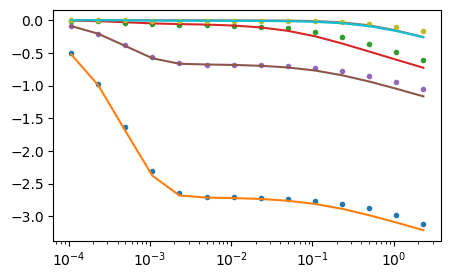

In [73]:
hm0_4 = w4.headinside(t0)[0]
hm1_4 = ml4.head(r1, 0, t1, layers=1)[0]
hm2_4 = ml4.head(r1, 0, t2, layers=13)[0]
hm3_4 = ml4.head(r2, 0, t3, layers=1)[0]
hm4_4 = ml4.head(r2, 0, t4, layers=13)[0]
plt.semilogx(t0, h0, ".", label="pumped")
plt.semilogx(t0, hm0_4, label="ttim pumped")
plt.semilogx(t1, h1, ".", label="PS1")
plt.semilogx(t1, hm1_4, label="ttim PS1")
plt.semilogx(t2, h2, ".", label="PD1")
plt.semilogx(t2, hm2_4, label="ttim PD1")
plt.semilogx(t3, h3, ",", label="PS2")
plt.semilogx(t3, hm3_4, label="ttim PS2")
plt.semilogx(t4, h4, ".", label="PD2")
plt.semilogx(t4, hm4_4, label="ttim PD2");

#### Step 7.1.1. Checking RMSE performance improvement

In [74]:
rmse_n = np.sqrt(
    np.sum(
        np.sum((h1 - hm1_4) ** 2)
        + np.sum((h2 - hm2_4) ** 2)
        + np.sum((h3 - hm3_4) ** 2)
        + np.sum((h4 - hm4_4) ** 2)
        + np.sum((h0 - hm0_4) ** 2)
    )
    / (len(h1) + len(h2) + len(h3) + len(h4) + len(h0))
)

print("RMSE:", rmse_n)

RMSE: 0.05070451405173345


## Step 8. Summary of and analysis of calibrated values and model errors

In [75]:
ta = pd.DataFrame(
    columns=["Moench", "Moench - more layers", "TTim", "TTim - more layers"],
    index=["k[m/d]", "Sy[-]", "Ss[1/m]", "kz/kh"],
)
ta.loc[:, "TTim - more layers"] = ca3.parameters["optimal"].values
ta.loc[:, "TTim"] = ca2.parameters["optimal"].values
ta.loc[:, "Moench"] = [kaq, Sy, Saq, kzoverkh]
ta.loc[:, "Moench - more layers"] = [kaq, Sy, Saq, kzoverkh]
ta.loc["RMSE"] = [rmse, rmse_n, ca2.rmse(), ca3.rmse()]
ta

,Moench,Moench - more layers,TTim,TTim - more layers
k[m/d],8.64,8.64,9.067633,8.695434
Sy[-],0.2,0.2,0.172888,0.196104
Ss[1/m],0.00002,0.00002,0.000039,0.000039
kz/kh,0.5,0.5,0.535053,0.488059
RMSE,0.061318,0.050705,0.010384,0.009767


The table above shows the TTim model results, with the first two columns showing the model simulated using Moench's parameters (Barlow and Moench, 1999). The first column is the original Model 1, and the second is the last model (Model 4) with more layers. Columns 3 and 4 show the results for the calibration with Conceptual Models 1 and 4.

Overall, the model accuracy improved when we added more layers, so the added complexity resulted in added accuracy. However, when we look at the calibrated data, we see that it did not improve calibration performance, and both the simple model and the more complex one had similar RMSE.

## References

* Barlow, P.M., Moench, A.F., 1999. WTAQ, a computer program for calculating drawdowns and estimating hydraulic properties for confined and water-table aquifers. 99-4225, US Dept. of the Interior, US Geological Survey
* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Kruseman, G.P., De Ridder, N.A., Verweij, J.M., 1970. Analysis and evaluationof pumping test data. volume 11. International institute for land reclamation and improvement The Netherlands.
* Moench, Allen, F., 1997. Flow to a well of finite diameter in a homogeneous, anisotropic water table aquifer. Water Resources Research 34, 2431–2432.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.